In [3]:
import numpy as np
import pandas as pd
import time
from __future__ import print_function

np.random.seed(2)  # reproducible


N_STATES = 6   # the length of the 1 dimensional world
ACTIONS = ['left', 'right']     # available actions
EPSILON = 0.9   # greedy police
ALPHA = 0.1     # learning rate
GAMMA = 0.9    # discount factor
MAX_EPISODES = 13   # maximum episodes
FRESH_TIME = 0.01    # fresh time for one move


def build_q_table(n_states, actions):
    table = pd.DataFrame(
        np.zeros((n_states, len(actions))),     # q_table initial values
        columns=actions,    # actions's name
    )
    # print(table)    # show table
    return table


def choose_action(state, q_table):
    # This is how to choose an action
    state_actions = q_table.iloc[state, :]
    if (np.random.uniform() > EPSILON) or (state_actions.all() == 0):  # act non-greedy or state-action have no value
        action_name = np.random.choice(ACTIONS)
    else:   # act greedy
        action_name = state_actions.argmax()
    return action_name


def get_env_feedback(S, A):
    # This is how agent will interact with the environment
    if A == 'right':    # move right
        if S == N_STATES - 2:   # terminate
            S_ = 'terminal'
            R = 1
        else:
            S_ = S + 1
            R = 0
    else:   # move left
        R = 0
        if S == 0:
            S_ = S  # reach the wall
        else:
            S_ = S - 1
    return S_, R


def update_env(S, episode, step_counter):
    # This is how environment be updated
    env_list = ['-']*(N_STATES-1) + ['T']   # '---------T' our environment
    if S == 'terminal':
        interaction = 'Episode %s: total_steps = %s' % (episode+1, step_counter)
        print('\r{}'.format(interaction), end='')
        time.sleep(2)
        print('\r                                ', end='')
    else:
        env_list[S] = 'o'
        interaction = ''.join(env_list)
        print('\r{}'.format(interaction), end='')
        time.sleep(FRESH_TIME)


def rl():
    # main part of RL loop
    q_table = build_q_table(N_STATES, ACTIONS)
    for episode in range(MAX_EPISODES):
        step_counter = 0
        S = 0
        is_terminated = False
        update_env(S, episode, step_counter)
        while not is_terminated:

            A = choose_action(S, q_table)
            S_, R = get_env_feedback(S, A)  # take action & get next state and reward
            q_predict = q_table.loc[S, A]
            if S_ != 'terminal':
                q_target = R + GAMMA * q_table.iloc[S_, :].max()   # next state is not terminal
            else:
                q_target = R     # next state is terminal
                is_terminated = True    # terminate this episode

            q_table.loc[S, A] += ALPHA * (q_target - q_predict)  # update
            S = S_  # move to next state

            update_env(S, episode, step_counter+1)
            step_counter += 1
    return q_table


if __name__ == "__main__":
    q_table = rl()
    print('\r\nQ-table:\n')
    print(q_table)

                                
Q-table:

       left     right
0  0.000001  0.005728
1  0.000271  0.032612
2  0.002454  0.111724
3  0.000073  0.343331
4  0.000810  0.745813
5  0.000000  0.000000


In [4]:
import tensorflow as tf

with tf.name_scope("a_name_scope"):
    initializer = tf.constant_initializer(value=1)
    var1 = tf.get_variable(name='var1', shape=[1], dtype=tf.float32, initializer=initializer)
    var2 = tf.Variable(name='var2', initial_value=[2], dtype=tf.float32)
    var21 = tf.Variable(name='var2', initial_value=[2.1], dtype=tf.float32)
    var22 = tf.Variable(name='var2', initial_value=[2.2], dtype=tf.float32)


with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    print(var1.name)        # var1:0
    print(sess.run(var1))   # [ 1.]
    print(var2.name)        # a_name_scope/var2:0
    print(sess.run(var2))   # [ 2.]
    print(var21.name)       # a_name_scope/var2_1:0
    print(sess.run(var21))  # [ 2.0999999]
    print(var22.name)       # a_name_scope/var2_2:0
    print(sess.run(var22))  # [ 2.20000005]

Instructions for updating:
Use `tf.global_variables_initializer` instead.
var1:0
[ 1.]
a_name_scope/var2:0
[ 2.]
a_name_scope/var2_1:0
[ 2.0999999]
a_name_scope/var2_2:0
[ 2.20000005]


In [5]:
with tf.variable_scope("a_variable_scope") as scope:
    initializer = tf.constant_initializer(value=3)
    var3 = tf.get_variable(name='var3', shape=[1], dtype=tf.float32, initializer=initializer)
    scope.reuse_variables()
    var3_reuse = tf.get_variable(name='var3',)
    var4 = tf.Variable(name='var4', initial_value=[4], dtype=tf.float32)
    var4_reuse = tf.Variable(name='var4', initial_value=[4], dtype=tf.float32)
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(var3.name)            # a_variable_scope/var3:0
    print(sess.run(var3))       # [ 3.]
    print(var3_reuse.name)      # a_variable_scope/var3:0
    print(sess.run(var3_reuse)) # [ 3.]
    print(var4.name)            # a_variable_scope/var4:0
    print(sess.run(var4))       # [ 4.]
    print(var4_reuse.name)      # a_variable_scope/var4_1:0
    print(sess.run(var4_reuse)) # [ 4.]

a_variable_scope/var3:0
[ 3.]
a_variable_scope/var3:0
[ 3.]
a_variable_scope/var4:0
[ 4.]
a_variable_scope/var4_1:0
[ 4.]


In [ ]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense
from keras.optimizers import Adam

BATCH_START = 0
TIME_STEPS = 20
BATCH_SIZE = 50
INPUT_SIZE = 1
OUTPUT_SIZE = 1
CELL_SIZE = 20
LR = 0.006

import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.Session(config=tf.ConfigProto(
  allow_soft_placement=True, log_device_placement=True))
    
def get_batch():
    global BATCH_START, TIME_STEPS
    # xs shape (50batch, 20steps)
    xs = np.arange(BATCH_START, BATCH_START+TIME_STEPS*BATCH_SIZE).reshape((BATCH_SIZE, TIME_STEPS)) / (10*np.pi)
    seq = np.sin(xs)
    res = np.cos(xs)
    BATCH_START += TIME_STEPS
    # plt.plot(xs[0, :], res[0, :], 'r', xs[0, :], seq[0, :], 'b--')
    # plt.show()
    return [seq[:, :, np.newaxis], res[:, :, np.newaxis], xs]

model = Sequential()
# build a LSTM RNN
model.add(LSTM(
    batch_input_shape=(BATCH_SIZE, TIME_STEPS, INPUT_SIZE),       # Or: input_dim=INPUT_SIZE, input_length=TIME_STEPS,
    output_dim=CELL_SIZE,
    return_sequences=True,      # True: output at all steps. False: output as last step.
    stateful=True,              # True: the final state of batch1 is feed into the initial state of batch2
))
# add output layer
model.add(TimeDistributed(Dense(OUTPUT_SIZE)))
adam = Adam(LR)
model.compile(optimizer=adam,
              loss='mse',)

print('Training ------------')
for step in range(501):
    # data shape = (batch_num, steps, inputs/outputs)
    X_batch, Y_batch, xs = get_batch()
    cost = model.train_on_batch(X_batch, Y_batch)
    pred = model.predict(X_batch, BATCH_SIZE)
    plt.plot(xs[0, :], Y_batch[0].flatten(), 'r', xs[0, :], pred.flatten()[:TIME_STEPS], 'b--')
    plt.ylim((-1.2, 1.2))
    plt.draw()
    plt.pause(0.1)
    if step % 10 == 0:
        print('train cost: ', cost)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(stateful=True, return_sequences=True, units=20, batch_input_shape=(50, 20, 1...)`


Training ------------


In [1]:
import os
os.environ['KERAS_BACKEND']='tensorflow'
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input
import matplotlib.pyplot as plt

import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.Session(config=tf.ConfigProto(
  allow_soft_placement=True, log_device_placement=True))

# download the mnist to the path '~/.keras/datasets/' if it is the first time to be called
# X shape (60,000 28x28), y shape (10,000, )
(x_train, _), (x_test, y_test) = mnist.load_data()

# data pre-processing
x_train = x_train.astype('float32') / 255. - 0.5       # minmax_normalized
x_test = x_test.astype('float32') / 255. - 0.5         # minmax_normalized
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))
print(x_train.shape)
print(x_test.shape)

# in order to plot in a 2D figure
encoding_dim = 2

# this is our input placeholder
input_img = Input(shape=(784,))

# encoder layers
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(10, activation='relu')(encoded)
encoder_output = Dense(encoding_dim)(encoded)

# decoder layers
decoded = Dense(10, activation='relu')(encoder_output)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='tanh')(decoded)

# construct the autoencoder model
autoencoder = Model(input=input_img, output=decoded)

# construct the encoder model for plotting
encoder = Model(input=input_img, output=encoder_output)

# compile autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# training
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,validation_data=(x_test, x_test))

# plotting
encoded_imgs = encoder.predict(x_test)
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y_test)
plt.colorbar()
plt.show()


Using TensorFlow backend.


(60000, 784)
(10000, 784)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 7s - loss: 0.0687 - val_loss: 0.0581
Epoch 2/20
60000/60000 [==============================] - 1s - loss: 0.0565 - val_loss: 0.0542
Epoch 3/20
60000/60000 [==============================] - 1s - loss: 0.0515 - val_loss: 0.0496
Epoch 4/20
60000/60000 [==============================] - 1s - loss: 0.0489 - val_loss: 0.0480
Epoch 5/20
60000/60000 [==============================] - 1s - loss: 0.0476 - val_loss: 0.0467
Epoch 6/20
60000/60000 [==============================] - 1s - loss: 0.0462 - val_loss: 0.0454
Epoch 7/20
60000/60000 [==============================] - 1s - loss: 0.0451 - val_loss: 0.0443
Epoch 8/20
60000/60000 [==============================] - 1s - loss: 0.0442 - val_loss: 0.0439
Epoch 9/20
60000/60000 [==============================] - 1s - loss: 0.0437 - val_loss: 0.0434
Epoch 10/20
60000/60000 [==============================] - 1s - loss: 0.0430 - val_loss: 0.0425

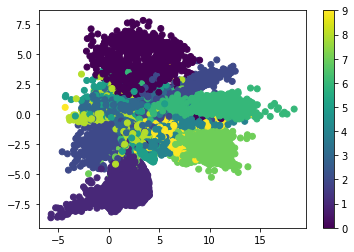

In [2]:
encoded_imgs = encoder.predict(x_test)
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [3]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense
from keras.optimizers import Adam

BATCH_START = 0
TIME_STEPS = 20
BATCH_SIZE = 50
INPUT_SIZE = 1
OUTPUT_SIZE = 1
CELL_SIZE = 20
LR = 0.006


def get_batch():
    global BATCH_START, TIME_STEPS
    # xs shape (50batch, 20steps)
    xs = np.arange(BATCH_START, BATCH_START+TIME_STEPS*BATCH_SIZE).reshape((BATCH_SIZE, TIME_STEPS)) / (10*np.pi)
    seq = np.sin(xs)
    res = np.cos(xs)
    BATCH_START += TIME_STEPS
    # plt.plot(xs[0, :], res[0, :], 'r', xs[0, :], seq[0, :], 'b--')
    # plt.show()
    return [seq[:, :, np.newaxis], res[:, :, np.newaxis], xs]

model = Sequential()
# build a LSTM RNN
model.add(LSTM(
    batch_input_shape=(BATCH_SIZE, TIME_STEPS, INPUT_SIZE),       # Or: input_dim=INPUT_SIZE, input_length=TIME_STEPS,
    output_dim=CELL_SIZE,
    return_sequences=True,      # True: output at all steps. False: output as last step.
    stateful=True,              # True: the final state of batch1 is feed into the initial state of batch2
))
# add output layer
model.add(TimeDistributed(Dense(OUTPUT_SIZE)))
adam = Adam(LR)
model.compile(optimizer=adam,
              loss='mse',)

print('Training ------------')
for step in range(501):
    # data shape = (batch_num, steps, inputs/outputs)
    X_batch, Y_batch, xs = get_batch()
    cost = model.train_on_batch(X_batch, Y_batch)
    pred = model.predict(X_batch, BATCH_SIZE)
    plt.plot(xs[0, :], Y_batch[0].flatten(), 'r', xs[0, :], pred.flatten()[:TIME_STEPS], 'b--')
    plt.ylim((-1.2, 1.2))
    plt.draw()
    plt.pause(0.1)
    if step % 10 == 0:
        print('train cost: ', cost)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(stateful=True, return_sequences=True, units=20, batch_input_shape=(50, 20, 1...)`


Training ------------
('train cost: ', 0.50940645)
('train cost: ', 0.3819961)
('train cost: ', 0.067545563)
('train cost: ', 0.1473687)
('train cost: ', 0.067293212)
('train cost: ', 0.073438108)
('train cost: ', 0.040334359)
('train cost: ', 0.046496928)
('train cost: ', 0.041025486)
('train cost: ', 0.033702768)
('train cost: ', 0.037701361)
('train cost: ', 0.029552707)
('train cost: ', 0.039870102)
('train cost: ', 0.02875975)
('train cost: ', 0.026678894)
('train cost: ', 0.020596839)
('train cost: ', 0.031524818)
('train cost: ', 0.035243534)
('train cost: ', 0.03007813)
('train cost: ', 0.033542752)
('train cost: ', 0.0080031604)
('train cost: ', 0.013353131)
('train cost: ', 0.0069769328)
('train cost: ', 0.0091835596)
('train cost: ', 0.012470359)
('train cost: ', 0.025230883)
('train cost: ', 0.034037739)
('train cost: ', 0.025201552)
('train cost: ', 0.020657387)
('train cost: ', 0.012327839)
('train cost: ', 0.017862609)
('train cost: ', 0.019502632)
('train cost: ', 0.015

In [6]:
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model

# create some data
X = np.linspace(-1, 1, 200)
np.random.shuffle(X)    # randomize the data
Y = 0.5 * X + 2 + np.random.normal(0, 0.05, (200, ))
X_train, Y_train = X[:160], Y[:160]     # first 160 data points
X_test, Y_test = X[160:], Y[160:]       # last 40 data points
model = Sequential()
model.add(Dense(output_dim=1, input_dim=1))
model.compile(loss='mse', optimizer='sgd')
for step in range(301):
    cost = model.train_on_batch(X_train, Y_train)

# save
print('test before save: ', model.predict(X_test[0:2]))
model.save('my_model.h5')   # HDF5 file, you have to pip3 install h5py if don't have it
del model  # deletes the existing model

# load
model = load_model('my_model.h5')
print('test after load: ', model.predict(X_test[0:2]))

# save and load weights
# model.save_weights('my_model_weights.h5')
# model.load_weights('my_model_weights.h5')
# save and load fresh network without trained weights
# from keras.models import model_from_json
# json_string = model.to_json()
# model = model_from_json(json_string)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1, input_dim=1)`
  from ipykernel import kernelapp as app


('test before save: ', array([[ 1.88323724],
       [ 2.18503165]], dtype=float32))
('test after load: ', array([[ 1.88323724],
       [ 2.18503165]], dtype=float32))


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [8]:
fig = plt.figure()
ax = Axes3D(fig)
# X, Y value
X = np.arange(-4, 4, 0.25)
Y = np.arange(-4, 4, 0.25)
X, Y = np.meshgrid(X, Y)    # x-y 平面的网格
R = np.sqrt(X ** 2 + Y ** 2)
# height value
Z = np.sin(R)

In [9]:
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
# X, Y value
X = np.arange(-4, 4, 0.25)
Y = np.arange(-4, 4, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X ** 2 + Y ** 2)
# height value
Z = np.sin(R)

ax.plot_surface(X, Y, Z, rstride=2, cstride=2, cmap=plt.get_cmap('rainbow'))

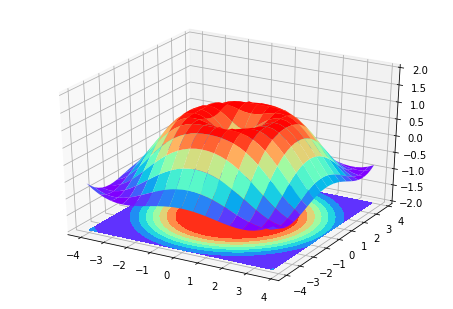

In [16]:
ax.contourf(X,Y,Z,zdir='z',offset=-2,cmap='rainbow')
ax.set_zlim(-2, 2)


plt.show()

[-1.   -0.25  0.5   1.25  2.  ]


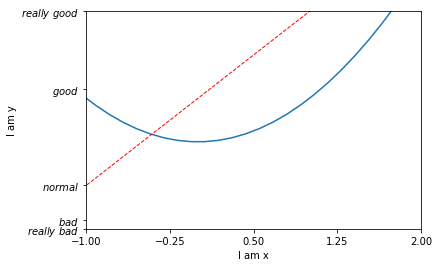

In [17]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-3, 3, 50)
y1 = 2*x + 1
y2 = x**2

plt.figure()
plt.plot(x, y2)
# plot the second curve in this figure with certain parameters
plt.plot(x, y1, color='red', linewidth=1.0, linestyle='--')
# set x limits
plt.xlim((-1, 2))
plt.ylim((-2, 3))
plt.xlabel('I am x')
plt.ylabel('I am y')

# set new sticks
new_ticks = np.linspace(-1, 2, 5)
print(new_ticks)
plt.xticks(new_ticks)
# set tick labels
plt.yticks([-2, -1.8, -1, 1.22, 3],
           [r'$really\ bad$', r'$bad$', r'$normal$', r'$good$', r'$really\ good$'])
plt.show()

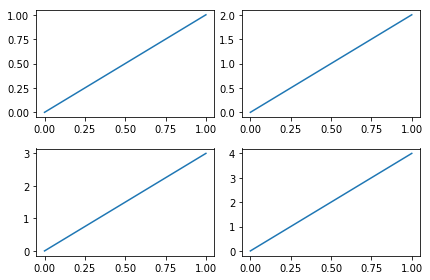

In [20]:
plt.figure(figsize=(6, 4))
# plt.subplot(n_rows, n_cols, plot_num)
plt.subplot(2, 2, 1)
plt.plot([0, 1], [0, 1])

plt.subplot(222)
plt.plot([0, 1], [0, 2])

plt.subplot(223)
plt.plot([0, 1], [0, 3])

plt.subplot(224)
plt.plot([0, 1], [0, 4])

plt.tight_layout()
plt.show()

In [24]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.figure()
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)  # stands for axes
ax1.plot([1, 2], [1, 2])
ax1.set_title('ax1_title')
ax2 = plt.subplot2grid((3, 3), (1, 0), colspan=2)
ax3 = plt.subplot2grid((3, 3), (1, 2), rowspan=2)
ax4 = plt.subplot2grid((3, 3), (2, 0))
ax4.scatter([1, 2], [2, 2])
ax4.set_xlabel('ax4_x')
ax4.set_ylabel('ax4_y')
ax5 = plt.subplot2grid((3, 3), (2, 1))

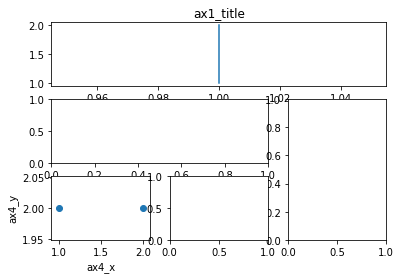

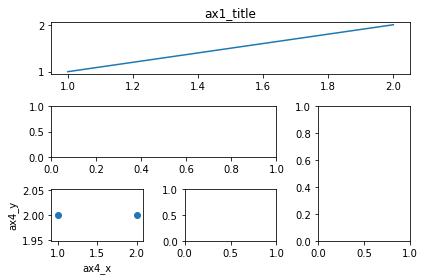

In [25]:
plt.tight_layout()
plt.show()

In [26]:
from __future__ import print_function
import pandas as pd

# merging two df by key/keys. (may be used in database)
# simple example
left = pd.DataFrame({'key': ['K0', 'K1', 'K2', 'K3'],
                                  'A': ['A0', 'A1', 'A2', 'A3'],
                                  'B': ['B0', 'B1', 'B2', 'B3']})
right = pd.DataFrame({'key': ['K0', 'K1', 'K2', 'K3'],
                                    'C': ['C0', 'C1', 'C2', 'C3'],
                                    'D': ['D0', 'D1', 'D2', 'D3']})
print(left)
print(right)
res = pd.merge(left, right, on='key')
print(res)

    A   B key
0  A0  B0  K0
1  A1  B1  K1
2  A2  B2  K2
3  A3  B3  K3
    C   D key
0  C0  D0  K0
1  C1  D1  K1
2  C2  D2  K2
3  C3  D3  K3
    A   B key   C   D
0  A0  B0  K0  C0  D0
1  A1  B1  K1  C1  D1
2  A2  B2  K2  C2  D2
3  A3  B3  K3  C3  D3


In [27]:
eft = pd.DataFrame({'key1': ['K0', 'K0', 'K1', 'K2'],
                             'key2': ['K0', 'K1', 'K0', 'K1'],
                             'A': ['A0', 'A1', 'A2', 'A3'],
                             'B': ['B0', 'B1', 'B2', 'B3']})
right = pd.DataFrame({'key1': ['K0', 'K1', 'K1', 'K2'],
                              'key2': ['K0', 'K0', 'K0', 'K0'],
                              'C': ['C0', 'C1', 'C2', 'C3'],
                              'D': ['D0', 'D1', 'D2', 'D3']})
print(left)
print(right)
res = pd.merge(left, right, on=['key1', 'key2'], how='inner')  # default for how='inner'

    A   B key
0  A0  B0  K0
1  A1  B1  K1
2  A2  B2  K2
3  A3  B3  K3
    C   D key1 key2
0  C0  D0   K0   K0
1  C1  D1   K1   K0
2  C2  D2   K1   K0
3  C3  D3   K2   K0


KeyError: 'key1'